#### Setup

In [1]:
%pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

# take environment variables from .env.
load_dotenv(override=True) 

search_service_endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.getenv("AZURE_AI_SEARCH_API_KEY", "")) if len(os.getenv("AZURE_AI_SEARCH_API_KEY", "")) > 0 else DefaultAzureCredential()
index_name = os.getenv("AZURE_SEARCH_INDEX", "recommendationidx")
azuresearch_fields_content_vector = os.getenv("AZURESEARCH_FIELDS_CONTENT_VECTOR", "contentVector")

#### Embed data using Cohere embed V3 without Vector DB
- Use embed-english-v3.0 model to embed the data with 1024 Dimentions and 512 Context window size

In [3]:
import cohere

# Initialize Cohere client
co = cohere.ClientV2()

In [4]:
# Chunk and load documents into AI search

from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = DirectoryLoader('data/', glob="*.md", loader_cls=TextLoader, loader_kwargs={'autodetect_encoding': True})
docs = loader.load()
documents = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
print(f"Loaded {len(documents)} documents")

Loaded 704 documents


In [5]:
# Extract page_content from each Document object
document_texts = [doc.page_content for doc in documents]

In [7]:
def generate_embeddings(texts, input_type="search_document"):
    model = "embed-english-v3.0"
    # Ensure texts is a list
    if isinstance(texts, str):
        texts = [texts]

    response = co.embed(
        texts=texts,
        model=model,
        input_type=input_type,
        embedding_types=["int8"],
    )
    return [embedding for embedding in response.embeddings.int8]


In [8]:
import time

# Limit to 80 calls per minute as Free Embed API has a limitation of 100 calls per min
batch_size = 80
embeddings = []
for i in range(0, len(document_texts), batch_size):
    batch = document_texts[i:i + batch_size]
    embeddings.extend(generate_embeddings(batch))
    if i + batch_size < len(document_texts):
        time.sleep(60)  # Sleep for 60 seconds to respect the rate limit

print (len(embeddings), "Document embeddings generated")

704 Document embeddings generated


In [9]:
%store embeddings

%store -r embeddings
print (len(embeddings), "Document embeddings loaded")

Stored 'embeddings' (list)
704 Document embeddings loaded


-------------------------------------------------------------------------------------------

In [26]:
from langchain.vectorstores import AzureSearch
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_cohere import ChatCohere
from langchain_core.output_parsers import StrOutputParser
from langchain_cohere import CohereEmbeddings

vector_store = AzureSearch(
    azure_search_endpoint=search_service_endpoint,
    azure_search_key=os.getenv("AZURE_AI_SEARCH_API_KEY"),
    index_name=index_name,
    embedding_function=CohereEmbeddings(model="embed-english-v3.0", embedding_types=["int8"]).embed_query,
    semantic_configuration_name="my-semantic-config",
    search_type="hybrid",
)

ai_search_retriever = vector_store.as_retriever(search_type="hybrid")

prompt = ChatPromptTemplate.from_template(
    """You are a personalized recommendation system for outdoor equipments that help users to find products that match their preferences. 
Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}

Question: {question}"""
)

# Define the Cohere LLM
llm = ChatCohere(model="command-r-plus-08-2024", temperature=0)

In [27]:
from operator import itemgetter
from typing import List
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import (
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)

def format_docs(docs: List[Document]) -> str:
    """Convert Documents to a single string.:"""
    formatted = [
        f"Article Title: {doc.metadata['title']}\nArticle Snippet: {doc.page_content}"
        for doc in docs
    ]
    return "\n\n" + "\n\n".join(formatted)


format = itemgetter("docs") | RunnableLambda(format_docs)
# subchain for generating an answer once we've done retrieval
answer = prompt | llm | StrOutputParser()
# complete chain that calls wiki -> formats docs to string -> runs answer subchain -> returns just the answer and retrieved docs.
chain = (
    RunnableParallel(question=RunnablePassthrough(), docs=ai_search_retriever)
    .assign(context=format)
    .assign(answer=answer)
    .pick(["answer", "docs"])
)

In [31]:
import pprint
output = chain.invoke("What were some of the recent purchases of Jane Doe?")
pprint.pprint(output)

{'answer': "Jane Doe's recent purchases include:\n"
           '- Adventurer Pro Backpack\n'
           '- TrekReady Hiking Boots',
 'docs': [Document(metadata={'id': '551', 'title': 'data/customer_2.md', '@search.score': 0.03333333507180214, '@search.reranker_score': None, '@search.highlights': None, '@search.captions': None}, page_content='## Customer_Info\n\nFirst Name: Jane \nLast Name: Doe \nAge: 28 \nEmail Address: janedoe@example.com \nPhone Number: 555-987-6543 \nShipping Address: 456 Oak St, Another City USA, 67890 \nMembership: Gold \n\n## Recent_Purchases\n\norder_number: 6 \ndate: 2023-01-10 \nitem:\n- description:  Adventurer Pro Backpack, quantity 1, price $90 \n\xa0 item_number: 2 \n \norder_number: 15 \ndate: 2023-01-20 \nitem:\n- description:  TrekReady Hiking Boots, quantity 1, price $140 \n\xa0 item_number: 4'),
          Document(metadata={'id': '438', 'title': 'data/customer_9.md', '@search.score': 0.016393441706895828, '@search.reranker_score': None, '@search.high

In [ ]:
output = chain.invoke("Suggest some products from the product catalogue that might interest Jane Doe, based on their purchase history?")
pprint.pprint(output)

{'answer': "Based on Jane Doe's recent purchases, it seems she is an outdoor "
           'enthusiast who enjoys hiking and backpacking. Here are some '
           'product suggestions that might interest her:\n'
           '\n'
           '- **Lightweight Hiking Poles:** These can be a great companion for '
           'her TrekReady Hiking Boots, providing extra support and balance on '
           'various terrains. Many modern hiking poles are adjustable and come '
           'with features like shock absorption and ergonomic grips, ensuring '
           'a comfortable and efficient hiking experience.\n'
           '\n'
           '- **Compact Camping Stove:** A portable stove could be a useful '
           'addition to her backpacking gear. This would allow her to cook '
           'meals efficiently during her outdoor adventures. Look for '
           'lightweight, fuel-efficient models that are easy to pack and '
           'carry.\n'
           '\n'
           '- **Water Filtrati

#### RAG with Langgraph to maintain chat history using Agentic AI

- Managing Context window techniques
1. Trim messages
2. Filter messages: The most straight-forward thing to do to prevent conversation history from blowing up is to filter the list of messages before they get passed to the LLM. 
3. Reset context window
4. Summarize and reset context window

In [13]:
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain.tools.retriever import create_retriever_tool
from langchain_cohere import ChatCohere

# Initialize the memory saver to maintain chat history
memory = MemorySaver()

@tool
def search(query: str):
    """Call to surf its existing knowledge base."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return "It's sunny in San Francisco."
    
retriever_tool = create_retriever_tool(
    ai_search_retriever,
    "retrieve_products_customers",
    "Search and return information about products and customers on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool, search]
tool_node = ToolNode(tools)
model = ChatCohere(model="command-r-plus-08-2024")
bound_model = model.bind_tools(tools)

def should_continue(state: MessagesState):
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # Otherwise if there is, we continue
    return "action"


# Define the function that calls the model
def call_model(state: MessagesState):
    response = bound_model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": response}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Next, we pass in the path map - all the possible nodes this edge could go to
    ["action", END],
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

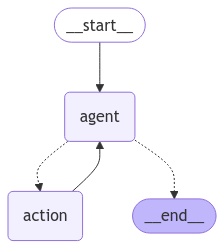

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [15]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="hi! I'm Jane Doe")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
input_message = HumanMessage(content="What are some products I recently purchased?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print() 
    
input_message = HumanMessage(content="Can you suggest products based on my previous purchase?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print() 

================================ Human Message =================================

hi! I'm Jane Doe
================================== Ai Message ==================================

Hi Jane Doe! How can I help you today?
================================ Human Message =================================

What are some products I recently purchased?
================================== Ai Message ==================================
Tool Calls:
  retrieve_products_customers (05ab8fc239604a2ca2fa5f8056886944)
 Call ID: 05ab8fc239604a2ca2fa5f8056886944
  Args:
    query: products purchased by Jane Doe
================================= Tool Message =================================
Name: retrieve_products_customers

## Customer_Info

First Name: Jane 
Last Name: Doe 
Age: 28 
Email Address: janedoe@example.com 
Phone Number: 555-987-6543 
Shipping Address: 456 Oak St, Another City USA, 67890 
Membership: Gold 

## Recent_Purchases

order_number: 6 
date: 2023-01-10 
item:
- description:  Adventure

#### Agentic RAG with Langgraph

- When it has to search over diverse set of sources
- When the question requires sequential reasoning
- When the question has multiple parts
- When it requires comparing multiple documents

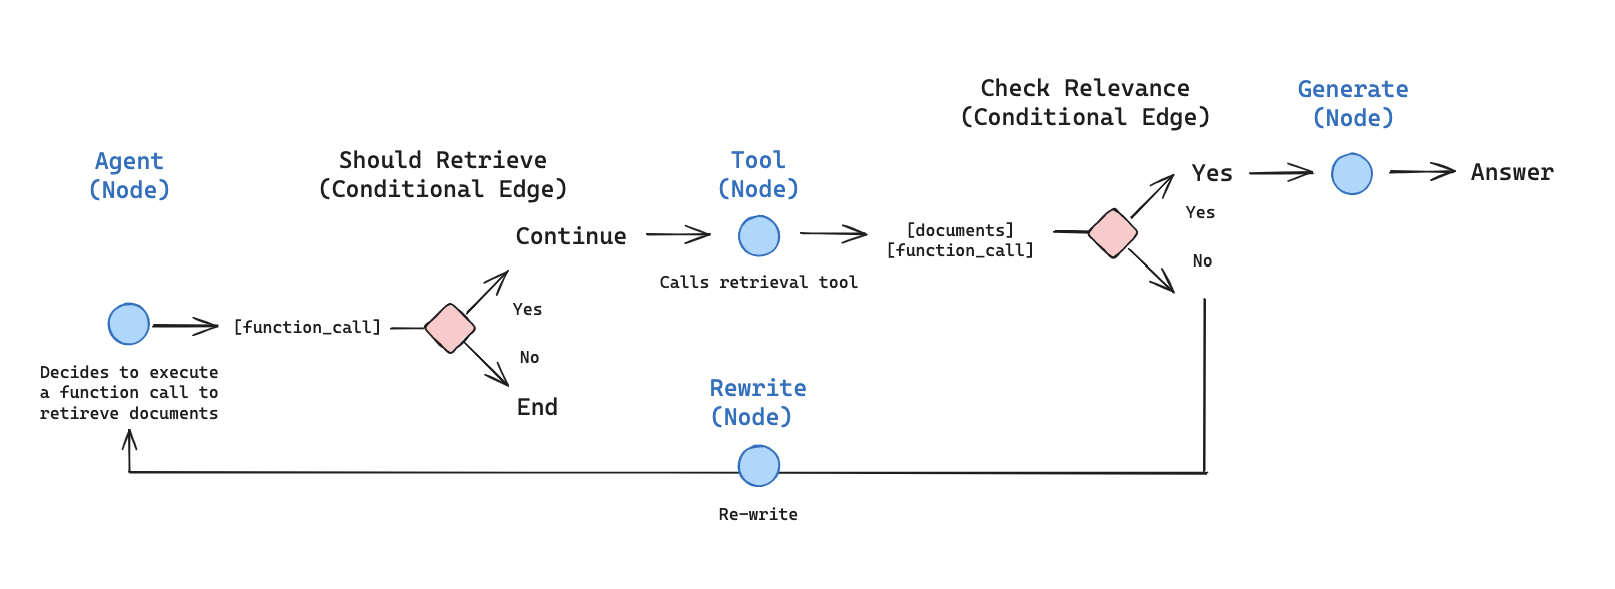

In [16]:
# Agent state: A list of messages

from typing import Annotated, Literal, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [17]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langchain_openai import AzureChatOpenAI

### Edges

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    # model = AzureChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
    model = ChatCohere(model="command-r-plus-08-2024", temperature=0, streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score
    # score = scored_result["binary_score"]

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = AzureChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
    # model = ChatCohere(model="command-r-plus-08-2024", temperature=0, streaming=True)
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    # model = AzureChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
    model = ChatCohere(model="command-r-plus-08-2024", temperature=0, streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    # llm = AzureChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
    llm = ChatCohere(model="command-r-plus-08-2024", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [18]:
## Generate the graph

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)
workflow.add_node("agent", agent) 
retrieve = ToolNode([retriever_tool, search])
workflow.add_node("retrieve", retrieve) 
workflow.add_node("rewrite", rewrite) 
workflow.add_node("generate", generate) 

workflow.add_edge(START, "agent")
# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

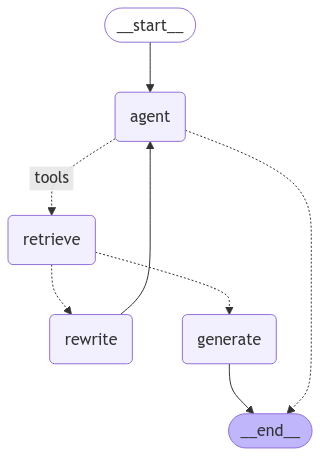

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
import pprint

inputs = {
    "messages": [
        ("user", "What are the features of the TrailMaster X4 Tent?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Y20uVPxEJClAOHPpBSlfBct7', 'function': {'arguments': '{"query":"TrailMaster X4 Tent features"}', 'name': 'retrieve_products_customers'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_fa1dad0729'}, id='run-5fb91b7a-f2c9-4a93-8271-5b21354db2cf-0', tool_calls=[{'name': 'retrieve_products_customers', 'args': {'query': 'TrailMaster X4 Tent features'}, 'id': 'call_Y20uVPxEJClAOHPpBSlfBct7', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content="4) Are there any additional accessories included with the TrailMaster X4 Tent?\n   The TrailMaster X4 Tent includes a rainfly, tent stakes, guy lines, and a carry bag for easy transport.\n\n5) Can the TrailMaster X4

In [22]:
inputs = {
    "messages": [
        ("user", "Suggest some products from the product catalogue that might be of interest to Jane Doe, based on their purchase history?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_DMaPBdVeLLm46qVnQIT4KJwC', 'function': {'arguments': '{"query":"Jane Doe purchase history"}', 'name': 'retrieve_products_customers'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_fa1dad0729'}, id='run-ae9b82ef-81dc-4dc6-9563-b79a54ea798e-0', tool_calls=[{'name': 'retrieve_products_customers', 'args': {'query': 'Jane Doe purchase history'}, 'id': 'call_DMaPBdVeLLm46qVnQIT4KJwC', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content="## Customer_Info\n\nFirst Name: Jane \nLast Name: Doe \nAge: 28 \nEmail Address: janedoe@example.com \nPhone Number: 555-987-6543 \nShipping Address: 456 Oak St, Another City USA, 67890 \nMembership: Gold \n\n## Recent_Pu

In [24]:
inputs = {
    "messages": [
        ("user", "Suggest the cheapest product to Jane Doe?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_gR7tNpMfBUc8pWvnU7r7cwGG', 'function': {'arguments': '{"query":"Jane Doe"}', 'name': 'retrieve_products_customers'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_fa1dad0729'}, id='run-2d7f1676-f1f6-4558-8250-9aba76142c1b-0', tool_calls=[{'name': 'retrieve_products_customers', 'args': {'query': 'Jane Doe'}, 'id': 'call_gR7tNpMfBUc8pWvnU7r7cwGG', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='## Customer_Info\n\nFirst Name: Jane \nLast Name: Doe \nAge: 28 \nEmail Address: janedoe@example.com \nPhone Number: 555-987-6543 \nShipping Address: 456 Oak St, Another City USA, 67890 \nMembership: Gold \n\n## Recent_Purchases\n\norder_number: 6 

In [23]:
inputs = {
    "messages": [
        ("user", "Suggest best reviewed products from the product catalogue that might be of interest to Jane Doe, based on their recent purchase history?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_H4Gi0Y5qsvJEQj6hAS8TlJ3V', 'function': {'arguments': '{"query":"Jane Doe recent purchase history"}', 'name': 'retrieve_products_customers'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_fa1dad0729'}, id='run-fdb56a6e-1322-48c0-a6b7-faf3104fb529-0', tool_calls=[{'name': 'retrieve_products_customers', 'args': {'query': 'Jane Doe recent purchase history'}, 'id': 'call_H4Gi0Y5qsvJEQj6hAS8TlJ3V', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content="## Customer_Info\n\nFirst Name: Jane \nLast Name: Doe \nAge: 28 \nEmail Address: janedoe@example.com \nPhone Number: 555-987-6543 \nShipping Address: 456 Oak St, Another City USA, 67890 \nMembership: 